# Finding the best line for data with errors in x and y

We want to find a straight line $y = a + bx$ fitting $N$ data points $X, Y = (X_i, Y_i)$ with errors $(\sigma(X_i), \sigma(Y_i))$,  $i=1,...,N$.  
We follow Yorks equations for the case of uncorrelated but non-constant errors (see references below for the inclusion of correlations between errors) which are derived by minimizing $$S = \sum_i \omega(X_i)(x_i-X_i)^2 + \omega(Y_i)(y_i-Y_i)^2,$$
where $(x_i, y_i)$ are the adjusted values that lie on the line and $(\omega(X_i), \omega(Y_i)) = (1/\sigma(X_i)^2, 1/\sigma(Y_i)^2)$ the weights. 

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.odr as so

## TL;DR: Quick How To

You can conveniently use the scipy package for orthogonal distance regression (ODR) to achieve this task.  
Check out https://docs.scipy.org/doc/scipy/reference/odr.html for documentation. Here I provide a short example.

Beta: [-0.4805337  5.4799117]
Beta Std Error: [ 0.07062028  0.35924657]
Beta Covariance: [[ 0.00336226 -0.01647255]
 [-0.01647255  0.08700776]]
Residual Variance: 1.483294149297378
Inverse Condition #: 0.09285611904588402
Reason(s) for Halting:
  Sum of squares convergence


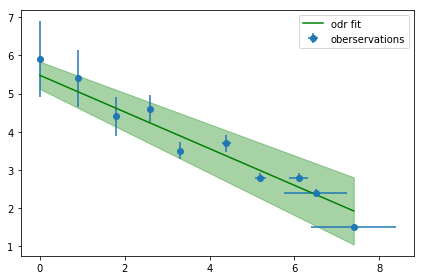

In [170]:
# 0. Test data
X = np.array([0.0, 0.9, 1.8, 2.6, 3.3, 4.4, 5.2, 6.1, 6.5, 7.4])
Y = np.array([5.9, 5.4, 4.4, 4.6, 3.5, 3.7, 2.8, 2.8, 2.4, 1.5])
wX = np.array([1000, 1000, 500, 800, 200, 80, 60, 20, 1.8, 1])
wY = np.array([1, 1.8, 4, 8, 20, 20, 70, 70, 100, 500])
sigma_x = 1.0/np.sqrt(wX)
sigma_y = 1.0/np.sqrt(wY)

# 1. Define the function you want to fit against.
def f(B, x):
   '''Linear function y = m*x + b'''
   return B[0]*x + B[1]

# 2. Create a Model.
linear = so.Model(f)

# 3. Create a Data or RealData instance.
mydata = so.RealData(X, Y, sx=sigma_x, sy=sigma_y) # should provide std errors not var

# 4. Instantiate ODR with your data, model and initial parameter estimate.
myodr = so.ODR(mydata, linear, beta0=[-0.5, 5.5])

# 5. Run the fit.
myoutput = myodr.run()

# 6. Examine output.
myoutput.pprint()
odr_b, odr_a = myoutput.beta
odr_sb, odr_sa = myoutput.sd_beta

# 7. Plot results
plt.figure(figsize=(6, 4))
plt.errorbar(X, Y, xerr=sigma_x, yerr=sigma_y, fmt='o', label='oberservations')
plt.plot(X, odr_a + odr_b * X, 'g-', label='odr fit')
# rough visualization of error estimates
plt.fill_between(X, odr_a-odr_sa + (odr_b-odr_sb)*X, odr_a+odr_sa + (odr_b+odr_sb)*X, color='g', alpha=0.35)
plt.legend()
plt.tight_layout()

This is all you need. If your interested in more details, go on. You can check our small python implementation for this task and some benchmarks to check its validity below.

# Further details
## Our python implementation
Inspired by the references below, we try a naive python implementation to learn how it works.

In [184]:
class York_eq_fit():
    debug = False
    
    def __init__(self, X, Y, SX, SY):
        """Observed points X,Y  (1d arrays) and standard error SX, SY."""
        
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.N = np.size(self.X) # number of obervations
        assert np.size(self.X) == np.size(self.Y), 'X and Y must have the same length'
        if np.size(SX) == 1:
            self.SX = np.ones(self.N) * SX
        else:
            assert np.size(SX) == self.N, 'SX and X must have the same length or SX must be a constant'
            self.SX = SX
        if np.size(SY) == 1:
            self.SY = np.ones(self.N) * SY
        else:
            assert np.size(SY) == self.N, 'SY and Y must have the same length or SX must be a constant'
            self.SY = SY            
        self.wX = 1.0 / self.SX**2  # weights of X observations
        self.wY = 1.0 / self.SY**2  # weights of Y observations
        
        # For later: include correlations (not implemented yet)
        self.alpha = np.sqrt(self.wX * self.wY)
        self.r = 0.0 # correlations between SX and SY
        
    def run(self, rtol=1e-15, atol=1e-10, maxiter=1000):
        """Perform fit and return result a,b and error estimates sa, sb"""
        
        self.guess_b()
        self.update_W()
        self.update_b()
        self.iterate(rtol, atol, maxiter)
        self.evaluate()
        return self.a, self.b, self.sa, self.sb

    def guess_b(self):
        """Find an initial guess for the slope b"""
        
        self.b, self.a = np.polyfit(self.X, self.Y, 1, w=1/self.SY)
        return self.b
    
    def update_W(self):
        """Update W given an estimate for b and knowing weights wX, wY"""
        
        self.W = self.wX * self.wY / (self.wX + self.b**2 * self.wY - 2 * self.b * self.r * self.alpha)
        # also update quantities that directly depend on W
        self.MX = np.sum(self.W * self.X) / np.sum(self.W) 
        self.MY = np.sum(self.W * self.Y) / np.sum(self.W)
        self.U = self.X - self.MX
        self.V = self.Y - self.MY
        beta_correction = (self.b * self.U + self.V) * self.r / self.alpha
        self.beta = self.W * (self.U/self.wY + self.b*self.V/self.wX - beta_correction)
        
    def update_b(self):
        """Update the estimate of slope b"""
        
        self.old_b = self.b
        self.b = np.sum(self.W * self.beta * self.V) / np.sum(self.W * self.beta *self.U)
        
    def iterate(self, rtol=1e-15, atol=1e-10, maxiter=1000):
        self.iterations = 0
        while abs(self.old_b - self.b) / self.b > rtol or abs(self.old_b-self.b) > atol:
            if York_eq_fit.debug:
                print(self.iterations, abs(self.old_b-self.b)/self.b)
            # repeat iteration until estimate for b converges
            self.update_W()
            self.update_b()
            self.iterations += 1
            if self.iterations > maxiter:
                print('Maximum number of iterations reached.')
                break
        if York_eq_fit.debug:
            print('Iteration converged after {0} steps.'.format(self.iterations))
                
    def evaluate(self, prefactor=True):
        """Evaluate results for a, b, Sa, Sb"""
        
        self.update_W()
        self.a = self.MY - self.b * self.MX
        self.x = self.MX + self.beta  # adjusted values x_i
        self.mx = np.sum(self.W * self.x) / np.sum(self.W)
        self.u = self.x - self.mx 
        self.sb = np.sqrt(1.0 / (np.sum(self.W * self.u**2)))
        self.sa = np.sqrt(1.0 / np.sum(self.W) + self.mx**2 * self.sb**2)
        self.S = np.sum(self.W * (self.Y - self.X * self.b -self.a)**2)
        if prefactor:
            self.sb = self.sb * np.sqrt(self.S/(self.N-2))
            self.sa = self.sa * np.sqrt(self.S/(self.N-2))

## Test if our implementation works

In [172]:
# TEST CASE: Pearsons' data (copied from Reed Am. J. Phys. 60, 1 (1992))
X = np.array([0.0, 0.9, 1.8, 2.6, 3.3, 4.4, 5.2, 6.1, 6.5, 7.4])
Y = np.array([5.9, 5.4, 4.4, 4.6, 3.5, 3.7, 2.8, 2.8, 2.4, 1.5])
wX = np.array([1000, 1000, 500, 800, 200, 80, 60, 20, 1.8, 1])
wY = np.array([1, 1.8, 4, 8, 20, 20, 70, 70, 100, 500])
# weight = 1/errors**2 <-> error = 1/weight**0.5
sigma_x = 1.0/np.sqrt(wX)
sigma_y = 1.0/np.sqrt(wY)

In [173]:
# Do the fit with our code
fit = York_eq_fit(X, Y, sigma_x, sigma_y)
a, b, sa, sb = fit.run(rtol=1e-15, atol=1e-15, maxiter=1000)
print('Offset a, slope b, std a, std b')
print('Result:', a, b, sa, sb)

Offset a, slope b, std a, std b
Result: 5.47991022403 -0.480533407446 0.359246522551 0.0706202695288


In [148]:
# compare this with numpy results for regression of y on x (only errors in y considered!)
np_fit = np.polyfit(X, Y, 1, w=1/np.ones(np.size(X))*sigma_y)

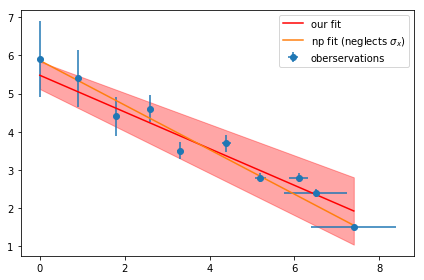

In [174]:
# plot data with results
plt.figure(figsize=(6, 4))
plt.errorbar(X, Y, xerr=sigma_x, yerr=sigma_y, fmt='o', label='oberservations')
plt.plot(X, fit.a+fit.b*X,'r-', label='our fit')
# rough visualization of error estimates
plt.fill_between(X, a-sa + (b-sb)*X, a+sa + (b+sb)*X, color='red', alpha=0.35)
plt.plot(X, np.polyval(np_fit, X), label=r'np fit (neglects $\sigma_x$)')

plt.legend()
plt.tight_layout()

We see that it makes quite a difference to neglect the errors in x. Of course it depends on your data set if the errors are marginal or not.

## Compare against scipy ODR

In [175]:
# Lets compare our code against scipy orthogonal distance regression, which should be correct.
import scipy.odr as so

#1. Define the function you want to fit against.
def f(B, x):
   '''Linear function y = m*x + b'''
   return B[0]*x + B[1]

#2. Create a Model.
linear = so.Model(f)

#3. Create a Data or RealData instance.
mydata = so.RealData(X, Y, sx=sigma_x, sy=sigma_y) # should provide std errors not var

# 4. Instantiate ODR with your data, model and initial parameter estimate.
myodr = so.ODR(mydata, linear, beta0=[-0.5, 5.5])

# 5. Run the fit.
myoutput = myodr.run()

# 6. Examine output.
myoutput.pprint()

odr_b, odr_a = myoutput.beta
odr_sb, odr_sa = myoutput.sd_beta

Beta: [-0.4805337  5.4799117]
Beta Std Error: [ 0.07062028  0.35924657]
Beta Covariance: [[ 0.00336226 -0.01647255]
 [-0.01647255  0.08700776]]
Residual Variance: 1.483294149297378
Inverse Condition #: 0.09285611904588402
Reason(s) for Halting:
  Sum of squares convergence


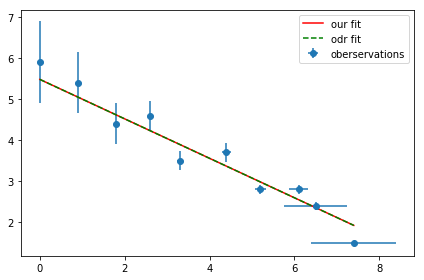

In [177]:
# Plot ODR fit against our python fit
plt.figure(figsize=(6, 4))
plt.errorbar(X, Y, xerr=sigma_x, yerr=sigma_y, fmt='o', label='oberservations')
plt.plot(X, fit.a+fit.b*X,'r-', label='our fit')
plt.plot(X, odr_a + odr_b * X, 'g--', label='odr fit')
plt.legend()
plt.tight_layout()

Very nice, the parameter estimates fall together perfectly! But what about the quality of error estimates?

## Comparison with a literature result

In [178]:
# literature results (copied from Reed 1992)
m, c = (-0.4805, 5.4799)
S = 11.866
sm_obs, sc_obs = (0.0702, 0.3555)
sm_adj, sc_adj = (0.0706, 0.3592) # these are the relevant ones if I understood correctly

In [179]:
# ODR agrees very well!
odr_a, odr_b, odr_sa, odr_sb

(5.4799116973248427,
 -0.48053369607371221,
 0.35924657332337567,
 0.070620283604428083)

In [180]:
# Our naive implementation agrees also! :)
prefactor = (S / np.size(X))
a, b, sa, sb

(5.4799102240328654,
 -0.48053340744620204,
 0.35924652255111161,
 0.070620269528770943)

## Monte Carlo testing
To check the methods, we sample our line many times and fit. By averaging we check if our estimates converge the same values and its sample variances match with the estimated variances.

In [181]:
results = []
results_odr = []; S_odr = []
repetitions = 2000
for i in range(repetitions):
    N = 101
    a = 1.105
    b = 0.577
    x = np.linspace(-1, 1, N)
    y = a + b * x
    sigma_x = 0.1
    sigma_y = 0.15
    error_x = np.random.randn(N) * sigma_x
    error_y = np.random.randn(N) * sigma_y
    X = x + error_x
    Y = y + error_x
    fit = York_eq_fit(X, Y, sigma_x, sigma_y)
    result = fit.run()
    results.append(result)

    mydata = so.RealData(X, Y, sx=sigma_x, sy=sigma_y)
    myodr = so.ODR(mydata, linear, beta0=[0.5, 1.])
    myoutput = myodr.run()
    result_odr = *myoutput.beta, *myoutput.sd_beta
    results_odr.append(result_odr)
    S_odr.append(myoutput.sum_square)


results = np.array(results)
results_odr = np.array(results_odr)

In [182]:
print('True values a, b:', a, b)
print('Average of estimates:', *np.mean(results, axis=0)[0:2]) 
print('Std of estimates:', *np.std(results, axis=0)[0:2])
print('Average of estimated std:', *np.mean(results, axis=0)[2:4])

True values a, b: 1.105 0.577
Average of estimates: 1.10520255442 0.589846574837
Std of estimates: 0.00412894724227 0.00687777975141
Average of estimated std: 0.00414292807003 0.00700781337182


In [183]:
print('True values b, a:', a, b)
print('Average of estimates:', *np.mean(results_odr, axis=0)[0:2][::-1]) 
print('Std of estimates:', *np.std(results_odr, axis=0)[0:2][::-1])
print('Average of estimated std:', *np.mean(results_odr, axis=0)[2:4][::-1])

True values b, a: 1.105 0.577
Average of estimates: 1.10520255487 0.589846356504
Std of estimates: 0.00412894922958 0.00687777845911
Average of estimated std: 0.00414292822783 0.00700781266149


## References
Derek York: Least-Squares Fitting of a Straight Line, Canadian Journal of Physics, 44 1079 (1966).  
http://www.nrcresearchpress.com/doi/10.1139/p66-090#.W7pY7Wgzb4Y  

B. Cameron Reed: Linear least-squares fits..  
https://aapt.scitation.org/doi/10.1119/1.15963  

Reed: Comments on parameter variances...    
https://aapt.scitation.org/doi/10.1119/1.17044  

Derek York, Norman M. Evensen, Margarita Lopez Martinez and Jonas Basabe Delgado: Unified equations for the slope, intercept, and standard errors of the best straight line, Am. J. Phys. 72 3 (2004).   
https://aapt.scitation.org/doi/10.1119/1.1632486